In [61]:
import pnet_loader
import util
import Pnet
import ReactomeNetwork
import torch
import random
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import torch.nn.functional as F
import torch.nn as nn


pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '../../data/brca_tcga_pan_can_atlas_2018'

In [4]:
brca_rna, brca_cna, brca_tumor_type, brca_mut = util.load_tcga_dataset(path)

rna = brca_rna.dropna(axis=1)
rna = (rna-rna.mean())/rna.std()
rna = rna.dropna(axis=1)
cna = brca_cna.dropna(axis=1)
mut = brca_mut.dropna(axis=1)

genetic_data = {'rna': rna, 'cna': cna, 'mut': mut}
for gd in genetic_data:
    genetic_data[gd].index = [i[:12] for i in genetic_data[gd].index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [70]:
clinical = pd.read_csv('../../data/brca_tcga_pan_can_atlas_2018/data_clinical_patient.txt', delimiter='\t').loc[4:].set_index('#Patient Identifier')
survival_target = pd.DataFrame(clinical['Progress Free Survival (Months)']).astype(float)
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

In [80]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, survival_target, seed=0, dropout=0.2, lr=1e-3, weight_decay=1e-3,
                                                                           batch_size=64, epochs=300, early_stopping=True, input_dropout=0.5, gene_set=canc_genes)

Task defined: REG 
 if this is not the intended task please specify task
Given 3 Input modalities
Found 1066 overlapping indicies
Initializing Train Dataset
Found 686 overlapping genes
generated input DataFrame of size (853, 2058)
Initializing Test Dataset
Found 686 overlapping genes
generated input DataFrame of size (213, 2058)
Found 686 overlapping genes
Loss function used: MSELoss()
We are sending to cuda
Hit early stopping criteria


In [81]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

In [82]:
model.to('cpu')
y_pred = model.predict(x_test, additional_test).detach()

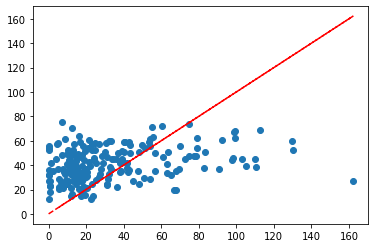

In [83]:
plt.scatter(x=y_test, y=y_pred)
plt.plot(y_test, y_test, color='red', linestyle='--', label='Diagonal Line')